In [1]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns

import statistics

import joblib

from sklearn.inspection import plot_partial_dependence

# Function

In [2]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1
def cal_score_all(cm_val):
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)
def setup(split):
    # setting split and path
    path = "../kitt/DATA_progress3_new/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    test_path =  "{}/test.csv".format(path)
    valid_path = "{}/{}/val/val.csv".format(path,split)

    print(train_path)
    # Load the train set
    train_data = pd.read_csv(train_path)
    print(train_data.shape)
    x_train = train_data[train_data.columns[2:]]
    print(x_train.shape)
    y_train = train_data[train_data.columns[1]]
    le = LabelEncoder()
    y_train = np.array(le.fit_transform(y_train))
    print(le.classes_)
    print(test_path)
    # Load the test set
    test_data = pd.read_csv(test_path)
    print(test_data.shape)
    x_test = test_data[test_data.columns[2:]]
    print(x_test.shape)
    y_test = test_data[test_data.columns[1]]
    le = LabelEncoder()
    y_test = np.array(le.fit_transform(y_test))
    print(le.classes_)

    print(valid_path)
    # Load the validation set
    val_data = pd.read_csv(valid_path)
    print(val_data.shape)
    x_val = val_data[val_data.columns[2:]]
    print(x_val.shape)
    y_val = val_data[val_data.columns[1]]
    le = LabelEncoder()
    y_val = np.array(le.fit_transform(y_val))
    print(le.classes_)

    # StandardScaler
    sc = StandardScaler()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    x_val = x_val.to_numpy()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    x_val = sc.transform(x_val)
    
    return x_train,y_train,x_test,y_test,x_val,y_val
def plot_cm(cm_val, save=False, title="-", split="-"):
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title(title+" {}".format(split), fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    if save is not False:
        save_path = '{}_{}.png'.format(save, split)
        plt.savefig(save_path)
        print("Save fig at {}".format(save_path))
    plt.show()
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')  
def thresholding(y_val, y_pred_val):
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_val[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    y_pred_val_new = to_labels(y_pred_val[:, 1], best_thresh)
    return y_pred_val_new
def plot_ROC():
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
def predict_set(split,param):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    loaded_model = joblib.load('model/param{}/SVM_model_{}.pkl'.format(param,split))
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    return y_val, y_pred_val, y_pred_val_raw
def ROC_split(param):
    split = "split1"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split2"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc2 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split3"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr3, tpr3, thr3 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc3 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split4"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr4, tpr4, thr4 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc4 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split5"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr5, tpr5, thr5 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc5 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    # gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    # ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC split1: %.2f%%" % auc1)
    print("AUC split2: %.2f%%" % auc2)
    print("AUC split3: %.2f%%" % auc3)
    print("AUC split4: %.2f%%" % auc4)
    print("AUC split5: %.2f%%" % auc5)
    
    plt.plot(fpr1,tpr1,label="ROC split 1, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC split 2, auc="+str("%.2f%%" % auc2))
    plt.plot(fpr3,tpr3,label="ROC split 3, auc="+str("%.2f%%" % auc3))
    plt.plot(fpr4,tpr4,label="ROC split 4, auc="+str("%.2f%%" % auc4))
    plt.plot(fpr5,tpr5,label="ROC split 5, auc="+str("%.2f%%" % auc5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

# def feature_impotance(split):
#     param = 2
#     loaded_model = joblib.load('model/param{}/SVM_model_{}.pkl'.format(param,split))
#     path = "../kitt/DATA_progress3/"
#     train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
#     train_data = pd.read_csv(train_path)
#     x_train = train_data[train_data.columns[2:]]
#     # get the best random forest model
#     # best_rfc = loaded_model.best_estimator_
#     # get the feature importances of the best random forest model
#     importances = loaded_model.feature_importances_
#     df = pd.DataFrame({'Variable':x_train.columns,
#               'Importance':importances}).sort_values('Importance', ascending=False)
#     indices = df.index
#     top_feature = df.iloc[0]['Variable']
#     second_feature = df.iloc[1]['Variable']
#     print("The most important feature in split {} is: {}".format(split, top_feature))
#     plt.figure(figsize=(12,6))
#     plt.title("Feature Importances")
#     plt.bar(range(x_train.shape[1]), importances[indices])
#     plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
#     plt.show()
#     return top_feature, second_feature
def false_predict_df(y_true, y_pred):
    """
    Compares two arrays and returns the indices of false predictions.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        The indices of false predictions.
    """
    path = "../kitt/DATA_progress3_new/"
    test_path =  "{}/test.csv".format(path)
    test_data = pd.read_csv(test_path)
    false_indices = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            false_indices.append(i)
    print(test_data.loc[false_indices])
    return false_indices

def false_predict(y_true, y_pred, split="test"):
    """
    Compares two arrays and returns the indices of false predictions.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        The indices of false predictions.
    """
    path = "../kitt/DATA_progress3/"
    false_positive = []
    false_negative = []
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    train_data = pd.read_csv(train_path)
    if split == "test":
        test_path =  "{}/test.csv".format(path)
        test_data = pd.read_csv(test_path)
        for i in range(len(y_true)):
            if y_true[i] != y_pred[i]:
                if y_pred[i] == 1:
                    false_positive.append(i)
                if y_pred[i] == 0:
                    false_negative.append(i)
        false_positive_df = test_data.loc[false_positive]
        false_negative_df = test_data.loc[false_negative]
        M_data = train_data[train_data["diagnosis"]=="M"]
        B_data = train_data[train_data["diagnosis"]=="B"]
    elif "split" in split:
        val_path =  "{}/{}/val/val.csv".format(path,split)
        val_data = pd.read_csv(val_path)
        false_indices = []
        for i in range(len(y_true)):
            if y_true[i] != y_pred[i]:
                if y_pred[i] == 1:
                    false_positive.append(i)
                if y_pred[i] == 0:
                    false_negative.append(i)
        false_positive_df = val_data.loc[false_positive]
        false_negative_df = val_data.loc[false_negative]
        M_data = train_data[train_data["diagnosis"]=="M"]
        B_data = train_data[train_data["diagnosis"]=="B"]
    x_col, y_col = "area_mean" , "concavity_mean"
    # Create the scatter plot with false predictions data as red dots and true predictions data as blue dots
    plt.scatter(B_data[x_col], B_data[y_col], color='blue', label='True Negative', alpha=0.5)
    plt.scatter(M_data[x_col], M_data[y_col], color='green', label='True Positive', alpha=0.5)
    plt.scatter(false_negative_df[x_col], false_negative_df[y_col], color='yellow', label='False Negative Predictions')
    plt.scatter(false_positive_df[x_col], false_positive_df[y_col], color='red', label='False Positive Predictions') 
    # Add legend and labels
    plt.legend()
    plt.title(split)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    # Show the plot
    plt.show()
    
#     # create a joint plot with a regression line
#     jp = sns.jointplot(x[x_col], x[y_col], kind='reg', data=df)

#     # add distribution plots
#     sns.histplot(x[x_col], ax=jp.ax_marg_x, color='purple')
#     sns.histplot(x[y_col], ax=jp.ax_marg_y, color='orange')

#     # set x and y labels
#     jp.set_axis_labels(x_col, y_col)

#     # show the plot
#     plt.show()

    return false_indices
def plot(split1_cm, split2_cm, split3_cm, split4_cm, split5_cm):
    cm_val = split1_cm + split2_cm + split3_cm + split4_cm + split5_cm
    # Calculate score
    print("split1")
    sen_val_1 = sensitivity(split1_cm)
    spec_val_1 = specificity(split1_cm)
    acc_val_1 = accuracy(split1_cm)
    pre_val_1 = precision(split1_cm)
    f1_score_val_1 = f1(split1_cm)
    print("\nsplit2")
    sen_val_2 = sensitivity(split2_cm)
    spec_val_2 = specificity(split2_cm)
    acc_val_2 = accuracy(split2_cm)
    pre_val_2 = precision(split2_cm)
    f1_score_val_2 = f1(split2_cm)
    print("\nsplit3")
    sen_val_3 = sensitivity(split3_cm)
    spec_val_3 = specificity(split3_cm)
    acc_val_3 = accuracy(split3_cm)
    pre_val_3 = precision(split3_cm)
    f1_score_val_3 = f1(split3_cm)
    print("\nsplit4")
    sen_val_4 = sensitivity(split4_cm)
    spec_val_4 = specificity(split4_cm)
    acc_val_4 = accuracy(split4_cm)
    pre_val_4 = precision(split4_cm)
    f1_score_val_4 = f1(split4_cm)
    print("\nsplit5")
    sen_val_5 = sensitivity(split5_cm)
    spec_val_5 = specificity(split5_cm)
    acc_val_5 = accuracy(split5_cm)
    pre_val_5 = precision(split5_cm)
    f1_score_val_5 = f1(split5_cm)
    print("\noverall")
    Mean_SD("sensitivity",sen_val_1, sen_val_2, sen_val_3, sen_val_4, sen_val_5)
    Mean_SD("specificity",spec_val_1, spec_val_2, spec_val_3, spec_val_4, spec_val_5)
    Mean_SD("accuracy",acc_val_1, acc_val_2, acc_val_3, acc_val_4, acc_val_5)
    Mean_SD("precision",pre_val_1, pre_val_2, pre_val_3, pre_val_4, pre_val_5)
    Mean_SD("f1_score",f1_score_val_1, f1_score_val_2, f1_score_val_3, f1_score_val_4, f1_score_val_5)
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black", fontsize=20)
    plt.show()
def Mean_SD(name,split1, split2, split3, split4, split5):
    sensitivity_values = []
    sensitivity_values.append(split1)
    sensitivity_values.append(split2)
    sensitivity_values.append(split3)
    sensitivity_values.append(split4)
    sensitivity_values.append(split5)

    # calculating the mean of sample set
    mean_sensitivity = statistics.mean(sensitivity_values)
    # Calculate standard deviation of sensitivity
    sensitivity_sd = statistics.stdev(sensitivity_values)
    
    # Print mean sensitivity with standard deviation
    print("%s: %.2f ± %.2f%%" % (name,mean_sensitivity, sensitivity_sd))
def evaluate(param,split):
    loaded_model = joblib.load('model/param{}/SVM_model_{}.pkl'.format(param,split))
    print("############## validate set ################")
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    
    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_val)
    
    # plot confusion matrix
    plot_cm(cm_val, title="Validate", split=split)
    
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test_raw = loaded_model.predict_proba(x_test)
    y_pred_test = thresholding(y_test, y_pred_test_raw)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_test)

    # plot confusion matrix
    plot_cm(cm_test, title="Test", split=split)

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.2f%%" % auc1)
    print("AUC test: %.2f%%" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    print("false_predict")
    print(false_predict_df(y_val, y_pred_val))
    false_predict(y_val, y_pred_val,split)
    return cm_val,cm_test,auc1,auc2

# split 1

../kitt/DATA_progress3_new//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
############## validate set ################
Best Threshold=0.416384
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


C:\Users\supak\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


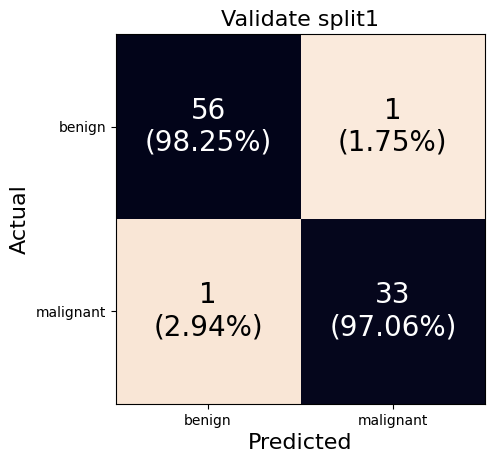

################# test set ##################
Best Threshold=0.455857
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split1
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


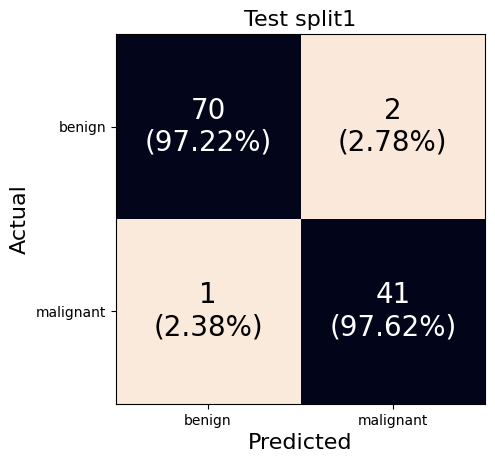

---------------------------------------
AUC validate: 99.69%
AUC test: 99.57%


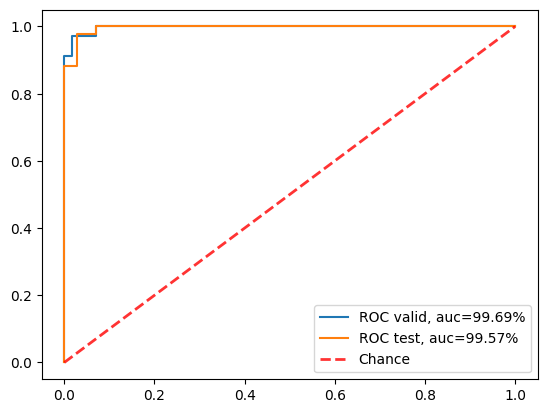

false_predict
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
36  914862         B         16.74      689.4          0.09883   
79   90291         M         23.29      664.7          0.08682   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
36         0.07721         0.1668                 0.06869      0.8423   
79         0.08390         0.1627                 0.05416      1.6270   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
36    34.84       0.004123       0.01996      0.01055              0.003237   
79    33.01       0.008312       0.03389      0.01740              0.002871   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
36            0.1135           0.1856          0.2177                  0.08549  
79            0.1312           0.2675          0.2477                  0.06836  
[36, 79]


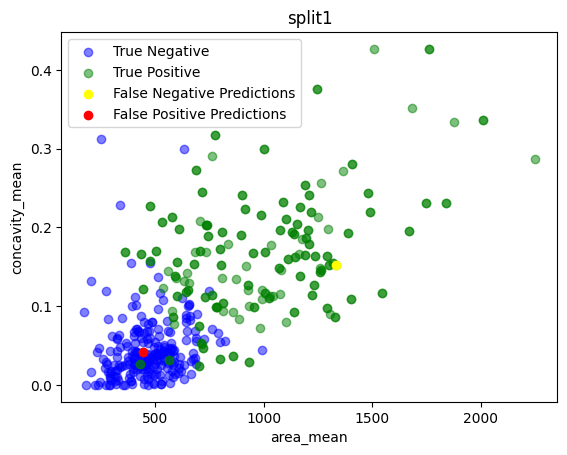

In [3]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
param = 2
param2_split1_cm_val, param2_split1_cm_test, param2_split1_AUC_val, param2_split1_AUC_test = evaluate(param,split)

In [4]:
# false_predict("split1")

# split 2

../kitt/DATA_progress3_new//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
############## validate set ################
Best Threshold=0.838663
FPR: 0.0175
TPR: 0.9412
Confusion Matrix
----------------
[[56  1]
 [ 2 32]] 

----------------
split2
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%


C:\Users\supak\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


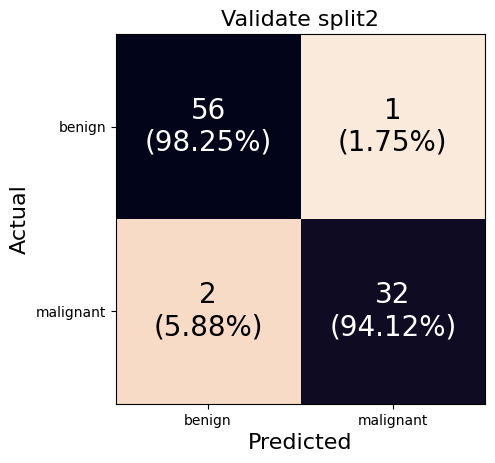

################# test set ##################
Best Threshold=0.625536
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split2
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


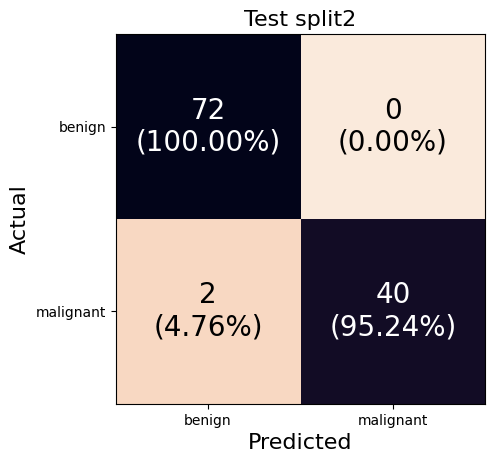

---------------------------------------
AUC validate: 99.38%
AUC test: 99.70%


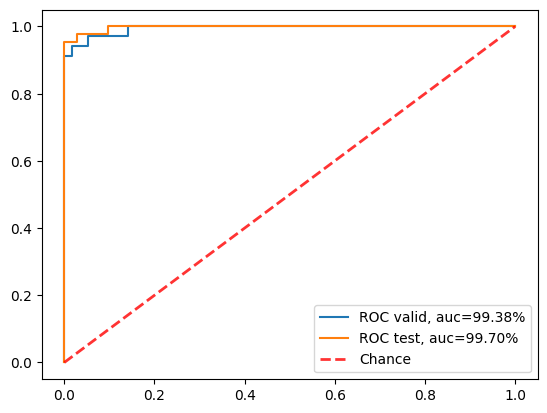

false_predict
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
12  861853         B         14.76      551.7          0.07355   
57  871641         B         14.71      372.7          0.10060   
87  889719         M         22.07      928.3          0.09726   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
12         0.03261         0.1386                 0.05318      1.1530   
57         0.02363         0.1566                 0.06669      1.8050   
87         0.09061         0.1867                 0.05580      0.7383   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
12    36.35       0.004481       0.01358      0.01069              0.001435   
57    19.08       0.014960       0.01453      0.03082              0.004785   
87    45.42       0.004493       0.02048      0.01144              0.001575   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
12            0.1006          

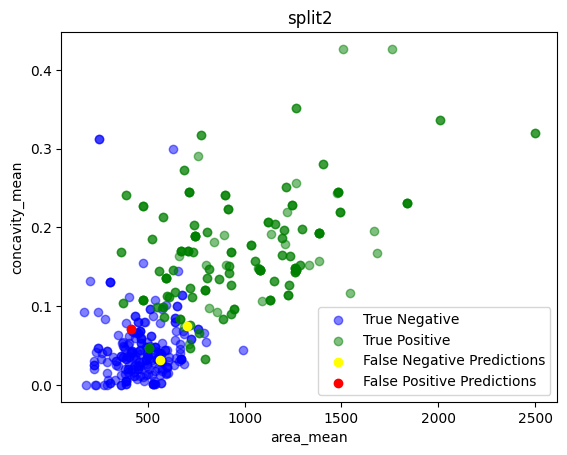

In [5]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
param = 2
param2_split2_cm_val, param2_split2_cm_test, param2_split2_AUC_val, param2_split2_AUC_test = evaluate(param,split)

# split 3

../kitt/DATA_progress3_new//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
############## validate set ################
Best Threshold=0.217653
FPR: 0.0351
TPR: 0.9706
Confusion Matrix
----------------
[[55  2]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%


C:\Users\supak\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


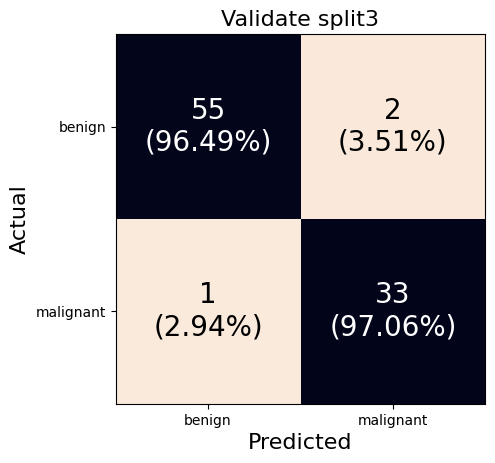

################# test set ##################
Best Threshold=0.594851
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split3
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


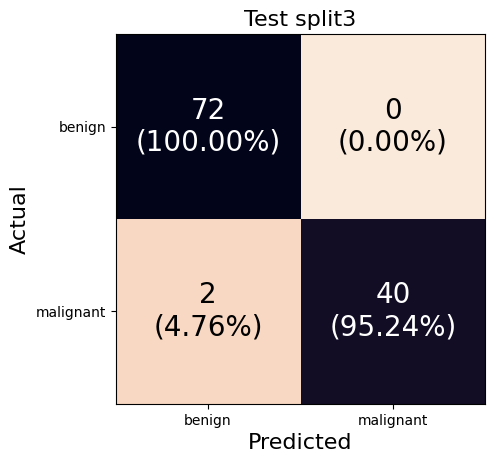

---------------------------------------
AUC validate: 98.56%
AUC test: 99.80%


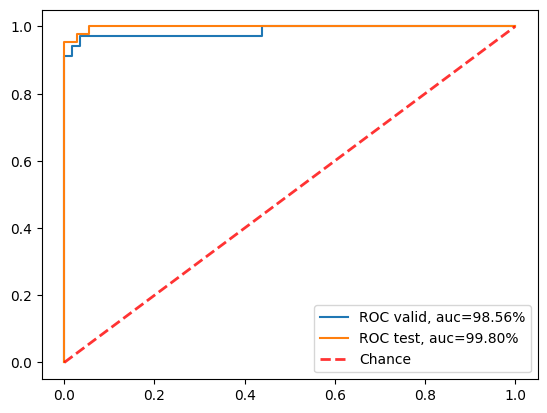

false_predict
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
1    923780         B         22.44      378.4          0.09566   
25  9113514         B         18.10      286.3          0.08311   
87   889719         M         22.07      928.3          0.09726   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
1          0.04824         0.2030                 0.06552      1.4670   
25         0.01479         0.1680                 0.06412      1.3120   
87         0.09061         0.1867                 0.05580      0.7383   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
1     17.85       0.003495       0.03445      0.02912              0.004723   
25    20.98       0.010980       0.01031      0.02693              0.002979   
87    45.42       0.004493       0.02048      0.01144              0.001575   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
1             0.1087      

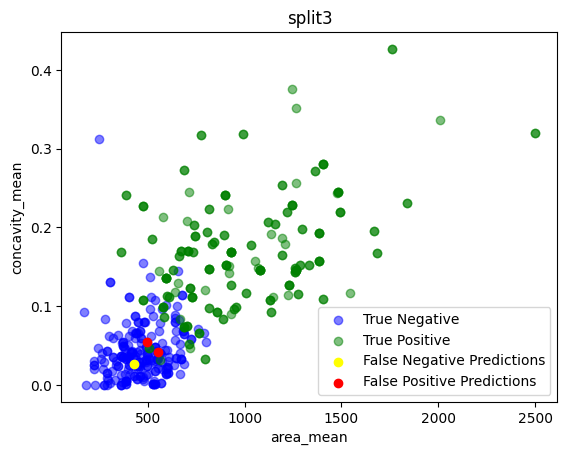

In [6]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
param = 2
param2_split3_cm_val, param2_split3_cm_test, param2_split3_AUC_val, param2_split3_AUC_test = evaluate(param,split)

# split 4

../kitt/DATA_progress3_new//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
############## validate set ################
Best Threshold=0.645649
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


C:\Users\supak\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


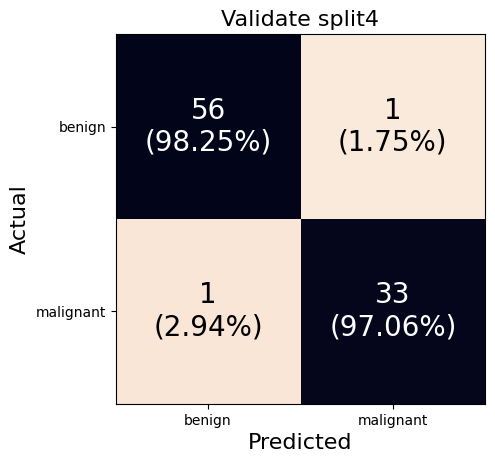

################# test set ##################
Best Threshold=0.580797
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


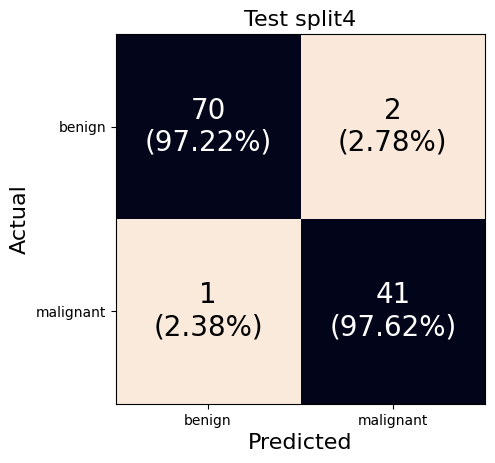

---------------------------------------
AUC validate: 99.69%
AUC test: 99.70%


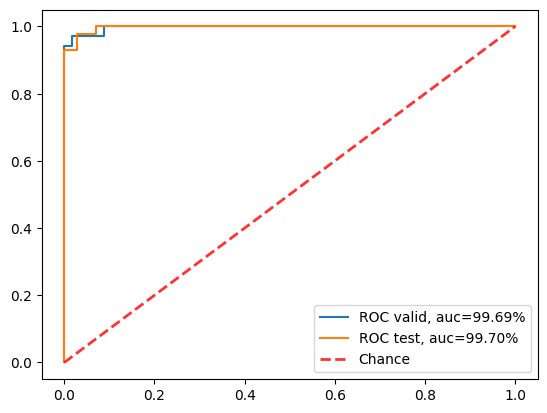

false_predict
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
37   863270         B         18.54      466.7          0.08477   
70  9012568         B         13.21      711.8          0.07963   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.02643         0.1602                 0.06066      0.8944   
70         0.03393         0.1721                 0.05544      0.4125   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
37    9.227       0.003457       0.01167      0.01251              0.001356   
70   17.720       0.005012       0.01551      0.01647              0.001767   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
37            0.1184           0.1937          0.2983                  0.07185  
70            0.1126           0.1362          0.2487                  0.06766  
[37, 70]


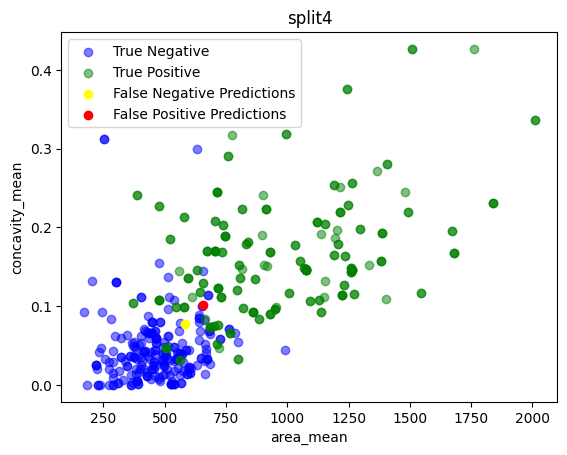

In [7]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
param = 2
param2_split4_cm_val, param2_split4_cm_test, param2_split4_AUC_val, param2_split4_AUC_test = evaluate(param,split)

# split 5

../kitt/DATA_progress3_new//split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
############## validate set ################
Best Threshold=0.704776
FPR: 0.0000
TPR: 1.0000
Confusion Matrix
----------------
[[57  0]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%


C:\Users\supak\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


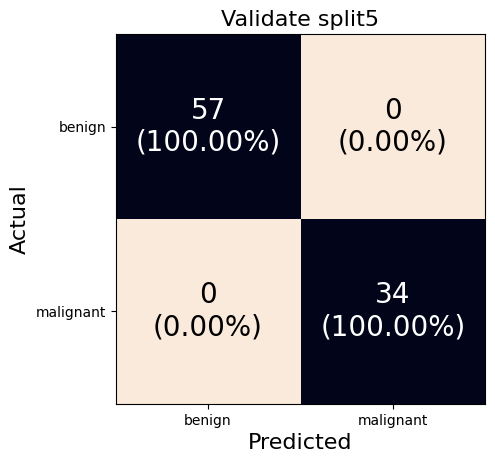

################# test set ##################
Best Threshold=0.663666
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


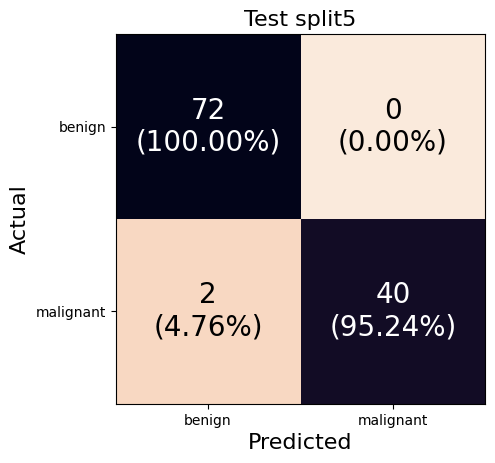

---------------------------------------
AUC validate: 100.00%
AUC test: 99.70%


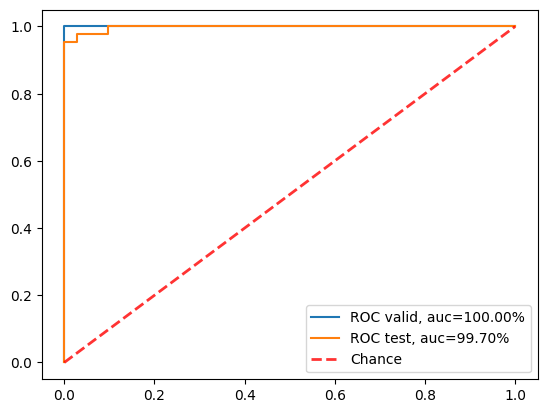

false_predict
Empty DataFrame
Columns: [id, diagnosis, texture_mean, area_mean, smoothness_mean, concavity_mean, symmetry_mean, fractal_dimension_mean, texture_se, area_se, smoothness_se, concavity_se, symmetry_se, fractal_dimension_se, smoothness_worst, concavity_worst, symmetry_worst, fractal_dimension_worst]
Index: []
[]


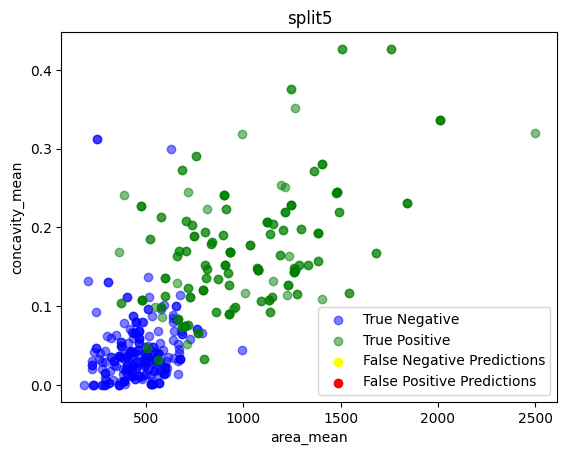

In [8]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
param = 2
param2_split5_cm_val, param2_split5_cm_test, param2_split5_AUC_val, param2_split5_AUC_test = evaluate(param,split)

# Overall

param2
split1
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split2
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%

split3
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%

overall
sensitivity: 97.06 ± 2.08%
specificity: 98.25 ± 1.24%
accuracy: 97.80 ± 1.35%
precision: 97.07 ± 2.02%
f1_score: 97.06 ± 1.80%


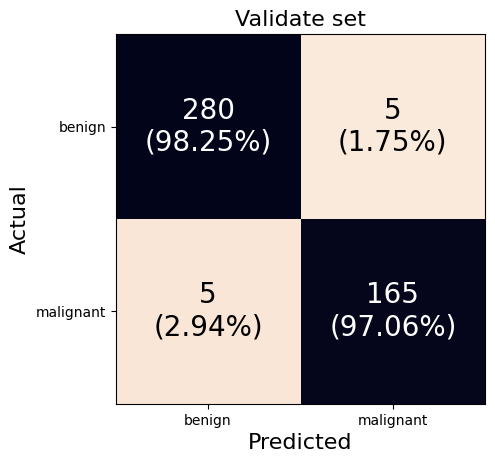

AUC2: 9946.34 ± 55.29%
../kitt/DATA_progress3_new//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.416384
FPR: 0.0175
TPR: 0.9706
../kitt/DATA_progress3_new//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.838663
FPR: 0.0175
TPR: 0.9412
../kitt/DATA_progress3_new//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.217653
FPR: 0.0351
TPR: 0.9706
../kitt/DATA_progress3_new//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//tes

C:\Users\supak\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\supak\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\supak\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info 

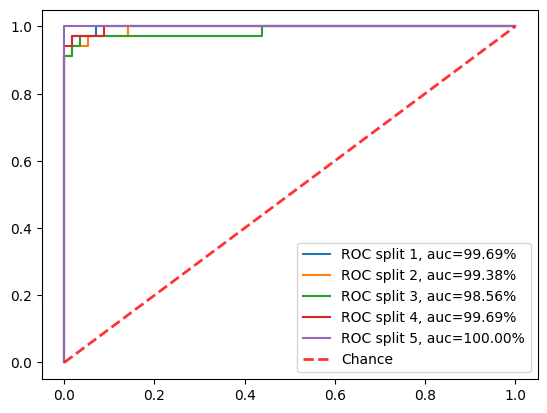

In [9]:
print("param2")
plot(param2_split1_cm_val , param2_split2_cm_val , param2_split3_cm_val , param2_split4_cm_val , param2_split5_cm_val)
Mean_SD("AUC2",param2_split1_AUC_val*100, param2_split2_AUC_val*100, param2_split3_AUC_val*100, param2_split4_AUC_val*100, param2_split5_AUC_val*100)
ROC_split(2)

# Final test

In [10]:
def final_param2():
    path = "../kitt/DATA_progress3_new/"
    train_path = "{}/train.csv".format(path)
    test_path =  "{}/test.csv".format(path)
    print(train_path)
    # Load the train set
    train_data = pd.read_csv(train_path)
    print(train_data.shape)
    x_train = train_data[train_data.columns[2:]]
    print(x_train.shape)
    y_train = train_data[train_data.columns[1]]
    le = LabelEncoder()
    y_train = np.array(le.fit_transform(y_train))
    print(le.classes_)
    print(test_path)
    # Load the test set
    test_data = pd.read_csv(test_path)
    print(test_data.shape)
    x_test = test_data[test_data.columns[2:]]
    print(x_test.shape)
    y_test = test_data[test_data.columns[1]]
    le = LabelEncoder()
    y_test = np.array(le.fit_transform(y_test))
    print(le.classes_)
    # StandardScaler
    sc = StandardScaler()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    model = SVC(C=100, gamma=0.001, kernel='rbf',probability=True)
    model.fit(x_train, y_train)
    joblib.dump(model, "../SVM_progress3/model/SVM_model_final.pkl")

In [11]:
final_param2()

../kitt/DATA_progress3_new//train.csv
(455, 18)
(455, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']


../kitt/DATA_progress3_new//train.csv
(455, 18)
(455, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
################# test set ##################
Best Threshold=0.537398
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


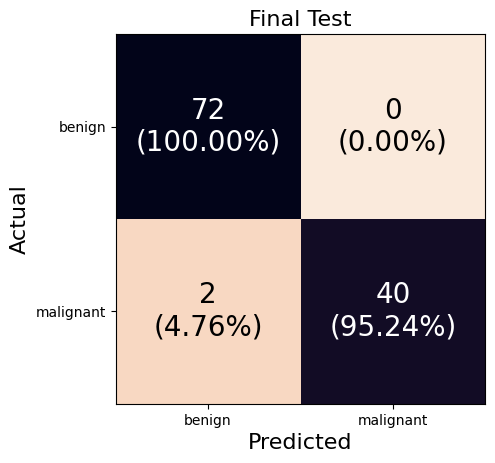

---------------------------------------
AUC test: 99.74%


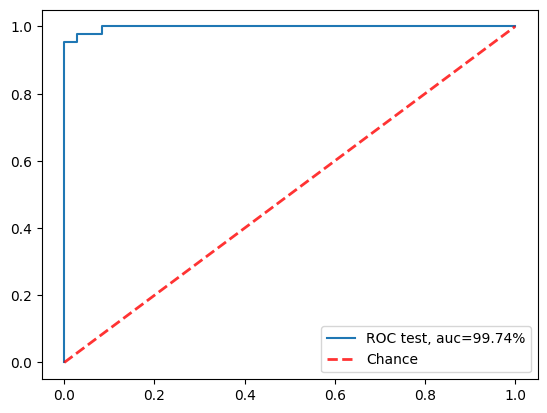

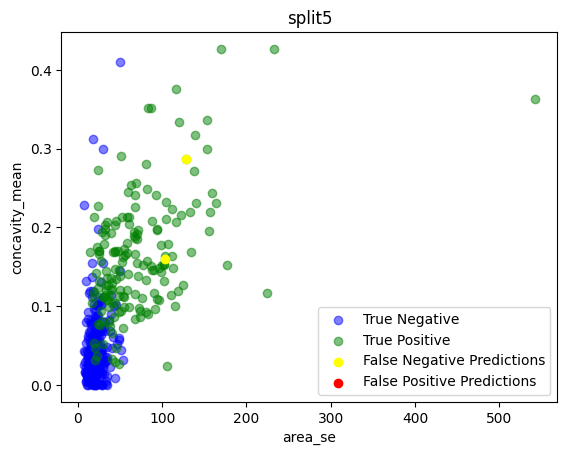

          id diagnosis  texture_mean  area_mean  smoothness_mean  \
100  8810987         M         16.93      578.9           0.1026   
110   889403         M         19.38      758.6           0.0784   

     concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
100         0.09901         0.2106                 0.06916      1.1940   
110         0.04209         0.1547                 0.05443      0.9988   

     area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
100    22.69       0.005960       0.03909      0.01939              0.004560   
110    22.18       0.002826       0.01311      0.01013              0.001345   

     smoothness_worst  concavity_worst  symmetry_worst  \
100            0.1460           0.4636          0.3630   
110            0.1084           0.2260          0.2683   

     fractal_dimension_worst  
100                  0.10590  
110                  0.06829  
[100, 110]


In [12]:
path = "../kitt/DATA_progress3_new/"
train_path = "{}/train.csv".format(path)
test_path =  "{}/test.csv".format(path)
print(train_path)
# Load the train set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)
print(test_path)
# Load the test set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)
# StandardScaler
sc = StandardScaler()
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
loaded_model = joblib.load('model/SVM_model_final.pkl')
# ################# test set ##################
label = ['benign','malignant']
print("################# test set ##################")
y_pred_test_raw = loaded_model.predict_proba(x_test)
y_pred_test = thresholding(y_test, y_pred_test_raw)

# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
cal_score_all(cm_test)

# plot confusion matrix
plot_cm(cm_test, title="Final", split="Test")

################## plot ROC curve ########################
fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
gmeans2 = np.sqrt(tpr2 * (1-fpr2))
ix2 = np.argmax(gmeans2)
print("---------------------------------------")
# print("AUC validate: %.2f%%" % auc1)
print("AUC test: %.2f%%" % auc2)
# plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

plt.legend(loc=4)
plt.show()
# return cm_val,cm_test,auc1,auc2

path = "../kitt/DATA_progress3/"
false_positive = []
false_negative = []
test_path =  "{}/test.csv".format(path)
test_data = pd.read_csv(test_path)
for i in range(len(y_test)):
    if y_test[i] != y_pred_test[i]:
        if y_pred_test[i] == 1:
            false_positive.append(i)
        if y_pred_test[i] == 0:
            false_negative.append(i)
false_positive_df = test_data.loc[false_positive]
false_negative_df = test_data.loc[false_negative]
M_data = train_data[train_data["diagnosis"]=="M"]
B_data = train_data[train_data["diagnosis"]=="B"]
    
x_col, y_col = "area_se", "concavity_mean"
# def feature_impotance(split):
loaded_model = joblib.load('model/SVM_model_final.pkl')
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
train_data = pd.read_csv(train_path)
x_train = train_data[train_data.columns[2:]]
# get the best random forest model
# best_rfc = loaded_model.best_estimator_
# get the feature importances of the best random forest model
# importances = loaded_model.feature_importances_
# df = pd.DataFrame({'Variable':x_train.columns,
#           'Importance':importances}).sort_values('Importance', ascending=False)
# indices = df.index
# top_feature = df.iloc[0]['Variable']
# second_feature = df.iloc[1]['Variable']
# print("The most important feature in split {} is: {}".format(split, top_feature))
# plt.figure(figsize=(12,6))
# plt.title("Feature Importances")
# plt.bar(range(x_train.shape[1]), importances[indices])
# plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
# plt.show()
    # return top_feature, second_feature
# Create the scatter plot with false predictions data as red dots and true predictions data as blue dots
plt.scatter(B_data[x_col], B_data[y_col], color='blue', label='True Negative', alpha=0.5)
plt.scatter(M_data[x_col], M_data[y_col], color='green', label='True Positive', alpha=0.5)
plt.scatter(false_negative_df[x_col], false_negative_df[y_col], color='yellow', label='False Negative Predictions')
plt.scatter(false_positive_df[x_col], false_positive_df[y_col], color='red', label='False Positive Predictions') 
# Add legend and labels
plt.legend()
plt.title(split)
plt.xlabel(x_col)
plt.ylabel(y_col)
# Show the plot
plt.show()
print(false_predict_df(y_test, y_pred_test))

# graph

In [13]:
# from sklearn.tree import export_graphviz
# import graphviz
# import joblib

In [14]:
# split = "split1"
# loaded_model = joblib.load('../RF_progress3/RF_model/RF_{}.joblib'.format(split))
# path = "../kitt/DATA_progress3/"
# train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
# train_data = pd.read_csv(train_path)
# x_train = train_data[train_data.columns[2:]]
# # y_train = train_data[train_data.columns[1]]

# # get the best random forest model
# best_rfc = loaded_model.best_estimator_
# # get the feature importances of the best random forest model
# importances = best_rfc.feature_importances_
# df = pd.DataFrame({'Variable':x_train.columns,
#           'Importance':importances}).sort_values('Importance', ascending=False)
# indices = df.index
# top_feature = df.iloc[0]['Variable']
# second_feature = df.iloc[1]['Variable']
# print("The most important feature in split {} is: {}".format(split, top_feature))
# plt.figure(figsize=(12,6))
# plt.title("Feature Importances")
# plt.bar(range(x_train.shape[1]), importances[indices])
# plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
# plt.show()

# # tree = loaded_model.estimators_[0]
# # Access the best model found during the search
# best_model = loaded_model.best_estimator_

# # Access the estimators_ attribute of the best model
# estimator = best_model.estimators_[0]

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = x_train.columns,
#                 class_names = train_data.columns[1],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')
# # dot_data = export_graphviz(tree, out_file=None, 
# #                            feature_names=x_train.columns,  
# #                            class_names=train_data.columns[1],
# #                            filled=True, rounded=True,  
# #                            special_characters=True)
# # graph = graphviz.Source(dot_data)  
# # graph.render("RF_tree") 
# # graph 

In [15]:
# x_train.columns

Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'area_se',
       'smoothness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se',
       'smoothness_worst', 'concavity_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')

In [16]:
# y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
# !dot -V

dot - graphviz version 8.0.3 (20230416.2022)
